In [1]:
import numpy as np
import matplotlib
from IPython.display import set_matplotlib_formats
from scipy.signal import lombscargle
from matplotlib import pyplot as plt
%matplotlib inline

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 6,6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

V1481A = np.array([24.36, -17.04, 13.26, 59.44, 45.43, -8.61, -9.37, 20.98, 63.91, -2.29, 55.55])
V1481B = np.array([96.34, 45.27, -43.73, -24.96, 78.60, 82.46, -50.16, 70.06, -37.94])
JD     = np.array([2453658.8320, 2453659.8226, 2453660.8243, 2453661.8003, 2453662.8240, 2453663.8200,
                   2453664.7964, 2453678.7838, 2453679.7282, 2453753.6614, 2453755.6823])
JDB    = np.array([2453659.8226, 2453660.8243, 2453661.8003, 2453662.8240, 2453663.8200,
                   2453664.7964, 2453679.7282, 2453753.6614, 2453755.6823])

DQTau1 = np.array([34.76, -2.93, 37.11, 37.38, 34.73, 31.64, 26.07, 23.51, 20.10, 17.31, 27.28, 36.99, 33.17,
                   35.11, 35.24, 28.81, 12.43, 40.09, 35.14, 35.89, 19.12, 37.08, 36.83, 12.75, -6.27, 14.82,
                   34.84,  3.16, 32.37, 39.09, 17.46, 22.67, 31.34])
DQTau2 = np.array([12.44, 56.13, 13.90, 15.01, 17.06, 20.70, 24.40, 27.30, 25.73, 27.86, 23.67, 7.64, 10.94,
                   09.87, 10.05, 19.93, 33.26, 13.83, 11.47, 16.98, 26.86, 10.20, 14.36, 23.86, 50.94, 37.61,
                   07.51, 52.75, 17.20, 08.27, 34.61, 26.25, 11.49])
HJD    = np.array([45982.0293, 46389.8446, 46745.8122, 47073.9364, 47075.9910, 47078.0084, 47127.8232, 47128.8081,
                   47159.6132, 47159.6318, 47427.9265, 47546.6122, 47546.6272, 47546.6272, 47546.6423, 47789.9412,
                   47840.8048, 47845.8709, 47896.7312, 47898.7686, 47902.6961, 48525.9580, 48670.6445, 48871.9572,
                   49344.8584, 49373.6908, 49410.6311, 49644.8270, 49699.8045, 53693.8806, 56578.9704, 56606.9106,
                   56650.8257])
#phase  = np.array([0.1435, 0.9520, 0.4794, 0.2446, 0.3747, 0.5023, 0.6549, 0.7172, 0.6667, 0.6679, 0.6468, 0.1579,
#                   0.1588, 0.1588, 0.1598, 0.5569, 0.7758, 0.0964, 0.3151, 0.4440, 0.6926, 0.1356, 0.2920, 0.0321,
#                   0.9596, 0.7842, 0.1220, 0.9430, 0.4223, 0.1867, 0.7691, 0.5373, 0.3164])
# These phases are those calculated by Czekala, et al.

In [124]:
#create period range from min and max possible values
def periods(t, f):
    delta_t = np.inf 
    for i in range(0, len(t)-2):
        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
            delta_t = t[i+1]-t[i]
    periods = np.linspace(2*delta_t, 100, num = f)
    return periods

In [125]:
#This periodogram code was taken from
#Jake Vanderplas' "Fast Lomb-Scargle Periodograms in Python"
#modified by myself into a function

def powers(t, rv, f):

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods(HJD, f)

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, rv - rv.mean(), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / (N * rv.std() ** 2)
    
    return powers

0.642852632639 15.7971923975


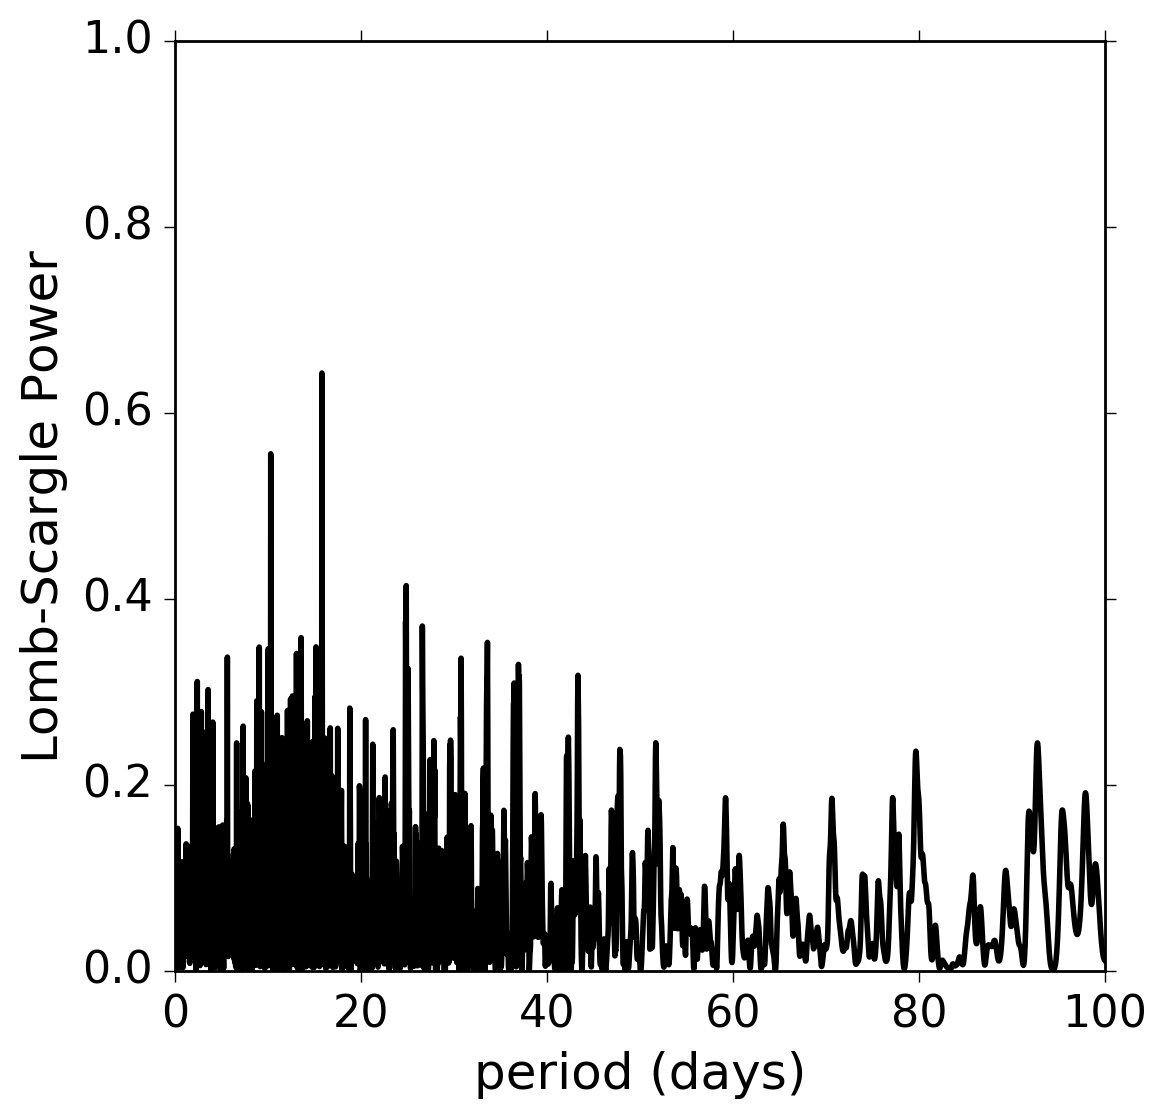

In [136]:
# plot the results
samples = 3000
x = periods(HJD, samples)
y = powers(HJD, DQTau1, samples)

fig, ax = plt.subplots()
ax.plot(x, y, 'k')
ax.set(ylim=(0, 1), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');
plt.savefig('DQTau1 periodogram.png')

print(np.amax(y), x[np.argmax(y)])